In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [6]:
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [7]:
vocab_size

27

In [18]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train,  Y_train  = build_dataset(words[:n1])     # 80%
X_dev, Y_dev = build_dataset(words[n1:n2])   # 10%
X_test,  Y_test  = build_dataset(words[n2:])     # 10%

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [19]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [20]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  learning_rate = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 25.5262
  10000/ 200000: 1.8644
  20000/ 200000: 2.1724
  30000/ 200000: 2.3769
  40000/ 200000: 2.7019
  50000/ 200000: 2.1173
  60000/ 200000: 2.7660
  70000/ 200000: 2.3996
  80000/ 200000: 1.9732
  90000/ 200000: 2.5869
 100000/ 200000: 2.3589
 110000/ 200000: 2.1763
 120000/ 200000: 2.0617
 130000/ 200000: 1.7896
 140000/ 200000: 2.5402
 150000/ 200000: 2.2238
 160000/ 200000: 1.9641
 170000/ 200000: 2.0778
 180000/ 200000: 2.4476
 190000/ 200000: 1.7866


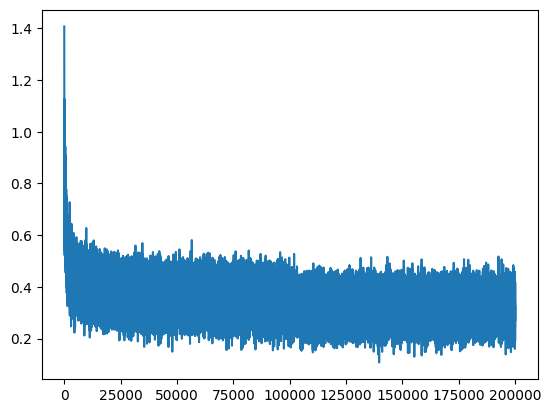

In [21]:
plt.plot(lossi)

In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
    'train': (X_train, Y_train),
    'val': (X_dev, Y_dev),
    'test': (X_test, Y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1236934661865234
val 2.1849231719970703


In [23]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ... and until we meet the 0th character again, 
    while True:
        embeddings = C[torch.tensor([context])] # (1, blocksize , d) # we're going to embed the current context using the embedding table C; usually here, the first dimension was the size of the training set, but here we're only using a single example that we're generating
        h = torch.tanh(embeddings.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) # exponentiates the logits and sum them to one and as with cross_entropy, it is careful so there's no overflows
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() # once we have the probabilities, we sample from them, using multinomial to get our next index and then
        
        context = context[1:] + [ix] # we shift our the context window to append the index and record it
        out.append(ix)
        # if we sample the special token '.', break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # we decode all the integers to strings and print them out

montalmyah.
seel.
nihayla.
rethrushadrie.
caderidieliigh.
poren.
eden.
van.
narah.
tylor.
kalin.
shrenzi.
hiriel.
kindreelynn.
nocalyn.
breyddi.
jamell.
els.
kayshianny.
mahil.


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  learning_rate = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 25.5262
  10000/ 200000: 1.8644
  20000/ 200000: 2.1724
  30000/ 200000: 2.3769
  40000/ 200000: 2.7019
  50000/ 200000: 2.1173
  60000/ 200000: 2.7660
  70000/ 200000: 2.3996
  80000/ 200000: 1.9732
  90000/ 200000: 2.5869
 100000/ 200000: 2.3589
 110000/ 200000: 2.1763
 120000/ 200000: 2.0617
 130000/ 200000: 1.7896
 140000/ 200000: 2.5402
 150000/ 200000: 2.2238
 160000/ 200000: 1.9641
 170000/ 200000: 2.0778
 180000/ 200000: 2.4476
 190000/ 200000: 1.7866


There's multiple things wrong with it. At the 0th iteration, there's loss ~25, whic hrapidly comes down to roughly 2 or so. <br>
This tell that the initialization os all messed up. You can calculate what to expect at this step in time. 

In [26]:
# There's 27 characters, so we would like is 1/27, and then the loss is negative log probability
-torch.tensor(1/27).log()

tensor(3.2958)

what's happening right now is that at initialization the neural net is creating probability distributions that are all messed up some characters are very confident and some characters are very not confident. <br>
basically what's happening is that the network is very confidently wrong

In [27]:
# 4D example of the issue
# we have 4 characters; the logits that come out of the NN are very close to zero
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # it doesn;t matter if the label is 2, or 3 or 1 or 0 because it's a uniform distribution
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [28]:
# if we manipulate the logits, we'll be changing the loss
# if we are assigning the correct probability at the initialization, by chance, to the correct label, and we get a very low loss
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # it doesn;t matter if the label is 2, or 3 or 1 or 0 because it's a uniform distribution
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

In [29]:
# if we manipulate the logits, we'll be changing the loss
# but it is much more likely we get something like
logits = torch.tensor([0.0, 5.0, .0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # it doesn;t matter if the label is 2, or 3 or 1 or 0 because it's a uniform distribution
probs, loss

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(5.0200))

In [33]:
# if we manipulate the logits, we'll be changing the loss

#logits = torch.tensor([0.0, 5.0, .0, 0.0])
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # it doesn;t matter if the label is 2, or 3 or 1 or 0 because it's a uniform distribution
logits, probs, loss

(tensor([-0.4234,  0.5427, -0.3130,  0.2737]),
 tensor([0.1481, 0.3891, 0.1654, 0.2974]),
 tensor(1.7995))

In [38]:
# if we manipulate the logits, we'll be changing the loss

#logits = torch.tensor([0.0, 5.0, .0, 0.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # it doesn;t matter if the label is 2, or 3 or 1 or 0 because it's a uniform distribution
logits, probs, loss

(tensor([-11.6389,   3.6007,  -2.7594,   7.9979]),
 tensor([2.9277e-09, 1.2162e-02, 2.1030e-05, 9.8782e-01]),
 tensor(10.7695))

In [47]:
# you see how because these are more extreme values it's very unlikely that you're going to be guessing the correct bucket and then you're confidently wrong and recording very high loss if your lodges are coming out even more extreme

#logits = torch.tensor([0.0, 5.0, .0, 0.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # it doesn;t matter if the label is 2, or 3 or 1 or 0 because it's a uniform distribution
logits, probs, loss

(tensor([27.8283, 10.3973,  2.3538,  1.5132]),
 tensor([1.0000e+00, 2.6902e-08, 8.6406e-12, 3.7280e-12]),
 tensor(25.4746))

In [51]:
# you see how because these are more extreme values it's very unlikely that you're going to be guessing the correct bucket and then you're confidently wrong and recording very high loss if your lodges are coming out even more extreme

logits = torch.randn(4) * 100 # <-- extreme logits
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # it doesn;t matter if the label is 2, or 3 or 1 or 0 because it's a uniform distribution
logits, probs, loss

(tensor([-156.0620,  -77.4451,  -94.6319,  134.3531]),
 tensor([0., 0., 0., 1.]),
 tensor(inf))